In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
df_cust_data = pd.read_excel('Customer_Data.xlsx')
df_plant = pd.read_excel('Plant Master.xlsx')
df_invoice = pd.read_csv('Final_invoice.csv',error_bad_lines=False, index_col=False, dtype='unicode')

In [3]:
remove_cols = []
for column in df_invoice.columns:
    
    if ((df_invoice[column].isnull().sum()*100)/len(df_invoice)) > 10:
        remove_cols.append(column)
        

df_invoice.drop(columns=remove_cols, axis = 1,inplace=True)

df_invoice.columns = df_invoice.columns.str.replace(r'[^\w\s]', '')
df_invoice.columns = df_invoice.columns.str.replace(' ', '')

df_invoice.columns = df_invoice.columns.str.upper()

In [4]:
df_invoice.columns

Index(['UNNAMED0', 'AREALOCALITY', 'CITY', 'CUSTTYPE', 'CUSTOMERNO',
       'DISTRICT', 'GATEPASSTIME', 'INVOICEDATE', 'INVOICENO', 'INVOICETIME',
       'JOBCARDNO', 'JOBCARDDATE', 'JOBCARDTIME', 'KMSREADING', 'LABOURTOTAL',
       'MAKE', 'MISCTOTAL', 'MODEL', 'OSLTOTAL', 'ORDERTYPE', 'PARTSTOTAL',
       'PINCODE', 'PLANT', 'PLANTNAME1', 'PRINTSTATUS', 'RECOVRBLEXP',
       'REGNNO', 'TOTALAMTWTDTAX', 'USERID'],
      dtype='object')

In [49]:
df_invoice.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 440143 entries, 0 to 492313
Data columns (total 32 columns):
UNNAMED0          440143 non-null object
AREALOCALITY      417330 non-null object
CITY              440143 non-null object
CUSTTYPE          440143 non-null object
CUSTOMERNO        440143 non-null object
DISTRICT          440143 non-null object
GATEPASSTIME      440143 non-null object
INVOICEDATE       440143 non-null object
INVOICENO         440143 non-null object
INVOICETIME       440143 non-null object
JOBCARDNO         440143 non-null object
JOBCARDDATE       440143 non-null object
JOBCARDTIME       440143 non-null object
KMSREADING        440143 non-null object
LABOURTOTAL       440143 non-null float64
MAKE              440143 non-null object
MISCTOTAL         440143 non-null float64
MODEL             438830 non-null object
OSLTOTAL          440143 non-null float64
ORDERTYPE         440143 non-null object
PARTSTOTAL        440143 non-null float64
PINCODE           440143

In [4]:
num_columns = ['LABOURTOTAL','MISCTOTAL','OSLTOTAL','PARTSTOTAL','TOTALAMTWTDTAX']
for col in num_columns:
    
    df_invoice[col].fillna(0)
    
    df_invoice[col] = df_invoice[col].astype(float)
    

df_invoice['UNNAMED0'] = df_invoice['UNNAMED0'].astype(int)

In [5]:
df_invoice.drop(index=df_invoice[df_invoice['TOTALAMTWTDTAX'] == 0].index,inplace=True)

df_invoice.drop(index=df_invoice[df_invoice['TOTALAMTWTDTAX'] < 0].index,inplace=True)

df_invoice.drop(index=df_invoice[df_invoice['LABOURTOTAL'] < 0].index,inplace=True)

In [21]:
df_invoice.shape

(440138, 29)

In [6]:
df_pincodes = pd.read_csv('Pincode.csv',error_bad_lines=False, index_col=False, dtype='unicode', encoding= 'unicode_escape')
df_pincodes = df_pincodes[['Pincode','District','StateName']]
df_pincodes.rename(columns={"District": "PO_District", "StateName": "PO_StateName"},inplace=True)
df_pincodes.sort_values(by=['Pincode','PO_District'],inplace=True)
df_pincodes.drop_duplicates(subset='Pincode', keep='first',inplace=True)
df_pincodes['PO_StateName'] = df_pincodes['PO_StateName'].str.upper()
df_pincodes['StateName'] = df_pincodes['PO_StateName']
df_invoice['DISTRICT'] = df_invoice['DISTRICT'].str.upper()

In [8]:
df_invalid_state = df_invoice[df_invoice['DISTRICT'] != df_invoice['StateName']].copy()
df_invalid_state['PO_District'] = df_invalid_state['CITY']
df_invalid_state['StateName'] = df_invalid_state['DISTRICT']
df_invalid_city = df_invalid_state[['CITY','PLANT']][df_invalid_state['CITY'].str.len() < 3].copy()
df_invalid_city = df_invalid_city.join(df_plant.set_index('Plant'), on='PLANT')

for index, row in df_invalid_city.iterrows(): 
    df_invalid_state.loc[index,'PO_District'] = row['City']

In [13]:
df_invoice.shape

(369814, 31)

In [10]:
#Drop records from invoice against invalid
df_invoice.drop(index=df_invalid_state.index,inplace=True)
#append invalid data in invoice data
df_final= pd.concat([df_invoice,df_invalid_state])
#Sort on column UNNAMED0 
df_final.sort_values(by='UNNAMED0',inplace=True)
#Drop Old City name / District 
df_final.drop(columns=['CITY','DISTRICT'],axis=1,inplace=True)
#Rename City name form Pincode data
df_final.rename(columns={"PO_District": "CITY", "StateName": "STATE"},inplace=True)
df_final['CITY'] = df_final['CITY'].str.upper()
df_final['STATE'] = df_final['STATE'].str.upper()

In [15]:
df_final.shape

(440138, 32)

In [16]:
df_final.columns

Index(['UNNAMED0', 'AREALOCALITY', 'CUSTTYPE', 'CUSTOMERNO', 'GATEPASSTIME',
       'INVOICEDATE', 'INVOICENO', 'INVOICETIME', 'JOBCARDNO', 'JOBCARDDATE',
       'JOBCARDTIME', 'KMSREADING', 'LABOURTOTAL', 'MAKE', 'MISCTOTAL',
       'MODEL', 'OSLTOTAL', 'ORDERTYPE', 'PARTSTOTAL', 'PINCODE', 'PLANT',
       'PLANTNAME1', 'PRINTSTATUS', 'RECOVRBLEXP', 'REGNNO', 'TOTALAMTWTDTAX',
       'USERID', 'CITY', 'STATE', 'JOBCARDDATETIME', 'INVOICEDATETIME',
       'SERVICETIME'],
      dtype='object')

In [14]:
#Combine date time for job card and invoice date time to calculate difference
df_final['JOBCARDDATETIME'] = pd.to_datetime(df_invoice['JOBCARDDATE'] + ' ' + df_invoice['JOBCARDTIME'])
df_final['INVOICEDATETIME'] = pd.to_datetime(df_invoice['INVOICEDATE'] + ' ' + df_invoice['INVOICETIME'])
df_final['SERVICETIME'] =(df_final['INVOICEDATETIME']-df_final['JOBCARDDATETIME']).astype('timedelta64[D]')

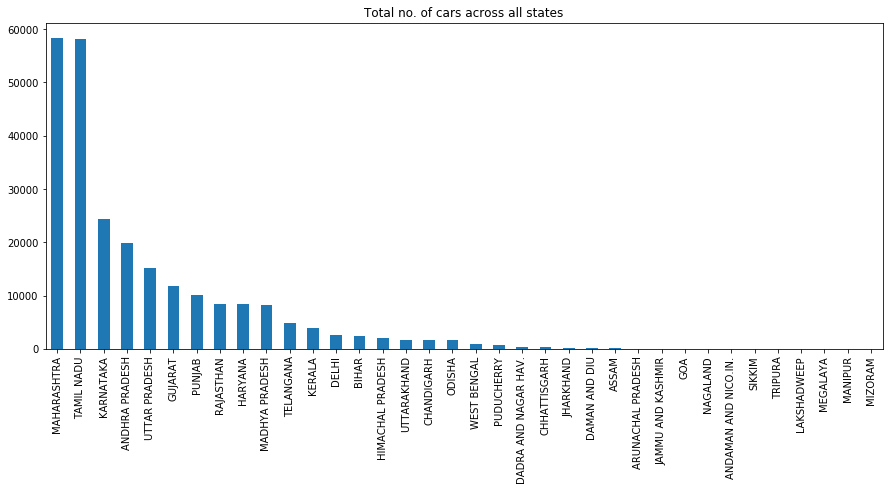

In [14]:
#For car we have mutiple entries in Invoice remove duplicate records 
df_car_regn = df_final[['REGNNO' , 'STATE','CITY','CUSTOMERNO','MAKE']].copy()
df_car_regn.sort_values(by=['REGNNO'],inplace=True)
df_car_regn.drop_duplicates(subset=['REGNNO'], keep='first',inplace=True)
#Which areas have most cars?
total_cars = df_car_regn['STATE'].value_counts() 
plot = total_cars.plot(kind='bar', title = "Total no. of cars across all states", figsize=(15,6))
plt.xticks(fontsize =10 , rotation=90);

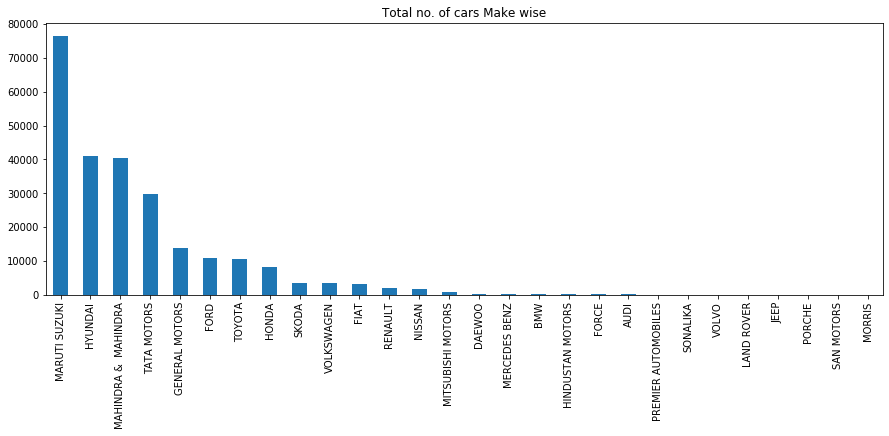

In [15]:
#Which make/car is more popular?
total_cars = df_car_regn['MAKE'].value_counts() 
plot = total_cars.plot(kind='bar', title = "Total no. of cars Make wise", figsize=(15,15))
plt.xticks(fontsize =10 , rotation=90);

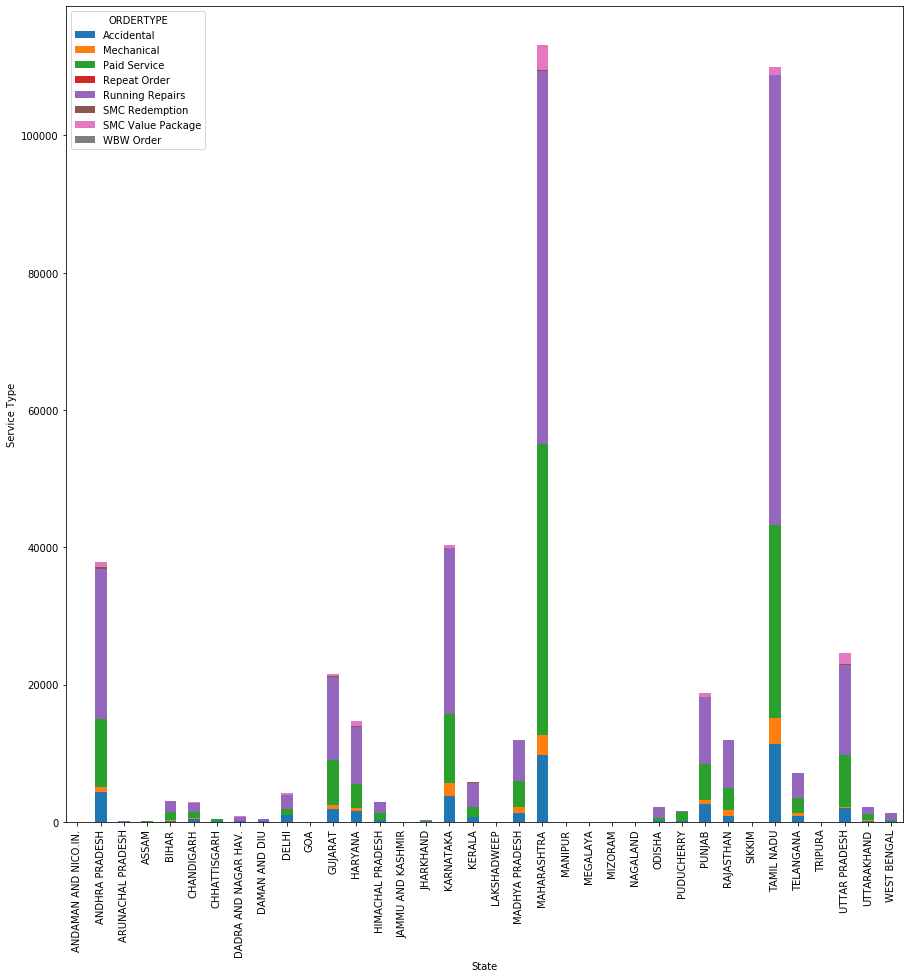

In [16]:
#Which type of service is popular in a certain area?
res = df_final.groupby(['STATE','ORDERTYPE']).size().unstack()
#print(res)
# Plot stacked bar chart
res.plot(kind='bar', stacked=True, figsize=(15,15))
plt.xlabel('State')
plt.ylabel('Service Type')
# Display plot
plt.show()

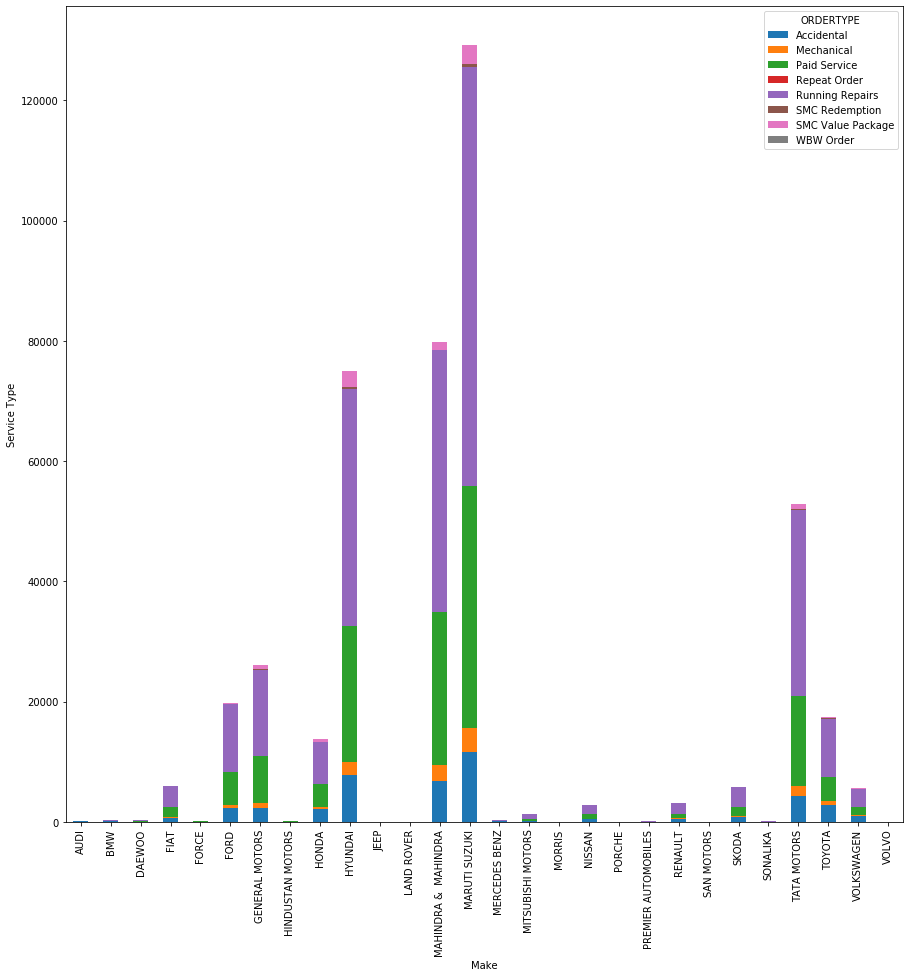

In [18]:
#What is service structure for particular make/car?
res = df_final.groupby(['MAKE','ORDERTYPE']).size().unstack()
#print(res)
# Plot stacked bar chart
res.plot(kind='bar', stacked=True, figsize=(15,15))
plt.ylabel('Service Type')
plt.xlabel('Make')
# Display plot
plt.show()

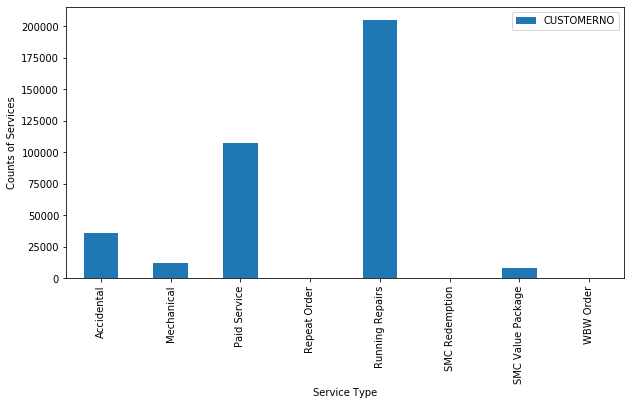

In [19]:
res = df_invoice.groupby(['ORDERTYPE']).count()['CUSTOMERNO'].to_frame()
#print(res)
# Plot stacked bar chart
res.plot(kind='bar', stacked=True, figsize=(10,5))
plt.xlabel('Service Type')
plt.ylabel('Counts of Services')
# Display plot
plt.show()

In [124]:
df_final.describe()

,UNNAMED0,LABOURTOTAL,MISCTOTAL,OSLTOTAL,PARTSTOTAL,TOTALAMTWTDTAX,SERVICETIME
count,440143.000000,440143.000000,440143.000000,440143.000000,440143.000000,440143.000000,369819.000000
mean,577973.238220,1514.101843,155.091206,521.316281,2725.421420,4915.930751,86.283550
std,312076.066329,3917.582711,1513.928543,2620.944173,8328.024096,11609.460190,282.879533
min,0.000000,-47.990000,0.000000,0.000000,0.000000,0.010000,0.000000
25%,560566.500000,199.400000,0.000000,0.000000,0.000000,496.580000,2.000000
50%,685556.000000,648.960000,0.000000,0.000000,607.310000,1942.270000,10.000000
75%,806398.500000,1424.965000,50.000000,0.000000,2636.280000,4998.650000,67.000000
max,984740.000000,323000.000000,350000.000000,119444.190000,598003.480000,648203.490000,17453.000000


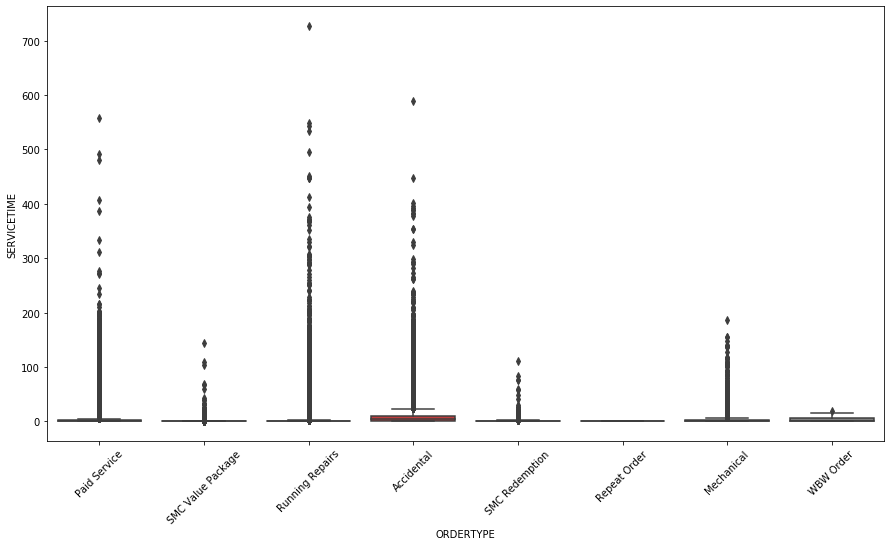

In [23]:
#Check outlier for service time 
import seaborn as sns
plt.figure(figsize=(15,8))
plt.xticks(rotation = 45)
sns.boxplot('ORDERTYPE', 'SERVICETIME', data=df_final)

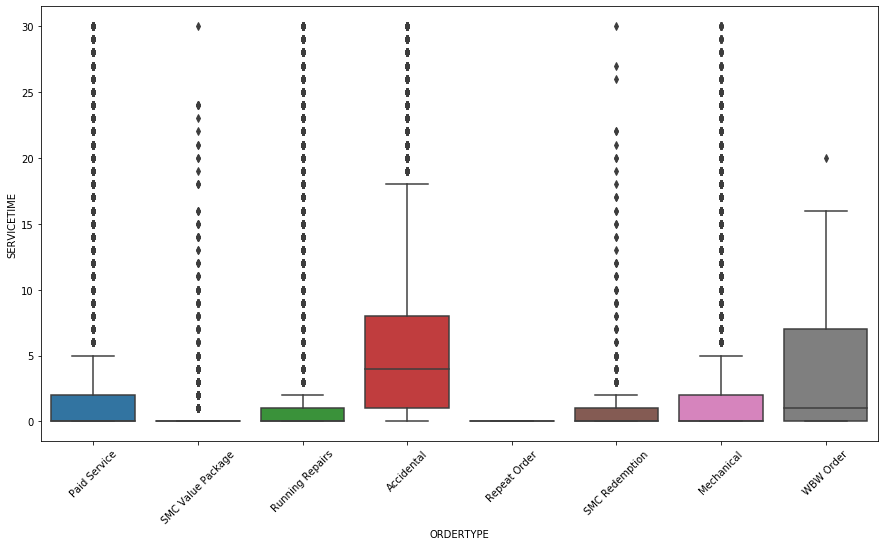

In [24]:
#Delete service took more than 30 days
res = df_final[df_final['SERVICETIME'] <= 30]
plt.figure(figsize=(15,8))
plt.xticks(rotation = 45)
sns.boxplot('ORDERTYPE', 'SERVICETIME', data=res)

In [17]:
from sklearn.cluster import KMeans
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
%matplotlib inline

In [35]:
df_final.columns

Index(['UNNAMED0', 'AREALOCALITY', 'CUSTTYPE', 'CUSTOMERNO', 'GATEPASSTIME',
       'INVOICEDATE', 'INVOICENO', 'INVOICETIME', 'JOBCARDNO', 'JOBCARDDATE',
       'JOBCARDTIME', 'KMSREADING', 'LABOURTOTAL', 'MAKE', 'MISCTOTAL',
       'MODEL', 'OSLTOTAL', 'ORDERTYPE', 'PARTSTOTAL', 'PINCODE', 'PLANT',
       'PLANTNAME1', 'PRINTSTATUS', 'RECOVRBLEXP', 'REGNNO', 'TOTALAMTWTDTAX',
       'USERID', 'CITY', 'STATE', 'JOBCARDDATETIME', 'INVOICEDATETIME',
       'SERVICETIME'],
      dtype='object')

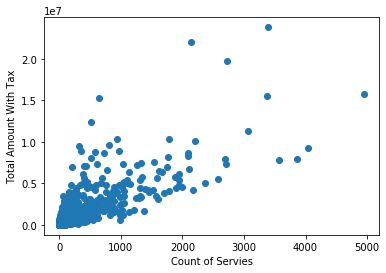

In [46]:
#Get the revnue based on State/City create dataframe on sum of labour count number of invoices
df_sum = pd.DataFrame(df_final.groupby(['STATE','CITY','MAKE','CUSTTYPE','ORDERTYPE']) \
                      ['LABOURTOTAL','MISCTOTAL','OSLTOTAL','PARTSTOTAL','TOTALAMTWTDTAX'].sum().reset_index())
df_count = pd.DataFrame(df_final.groupby(['STATE','CITY','MAKE','CUSTTYPE','ORDERTYPE'])['TOTALAMTWTDTAX'].count().reset_index())
df_count.rename(columns={"TOTALAMTWTDTAX": "COUNT"},inplace=True)
df = df_sum.merge(df_count, left_on=['STATE','CITY','MAKE','CUSTTYPE','ORDERTYPE'], \
                  right_on=['STATE','CITY','MAKE','CUSTTYPE','ORDERTYPE'])

plt.scatter(x=df['COUNT'],y=df['TOTALAMTWTDTAX'])
plt.xlabel('Count of Servies')
plt.ylabel('Total Amount With Tax')
plt.show()

In [67]:
df.to_csv('Spending_analysis.csv')

(75, 12)


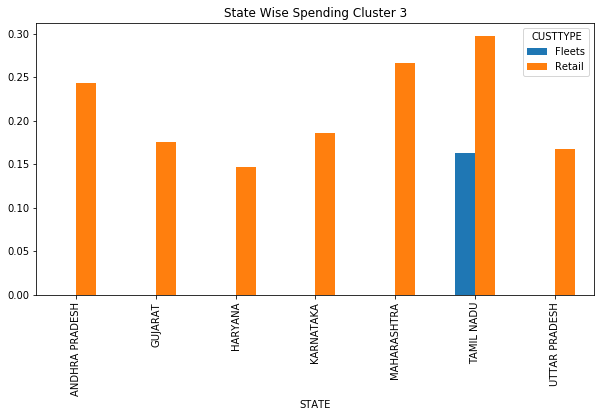

In [109]:
#For cluster with high cost group with customer type & Order type (Service)
res = df[df.cluster == 3]
print(res.shape)
res = res.pivot_table(index='STATE', columns='CUSTTYPE',values='TOTALAMTWTDTAX').reset_index()
res.plot(kind='bar', title = "State Wise Spending Cluster 3", figsize=(10,5),x='STATE')
plt.xticks(fontsize =10 , rotation=90);

(374, 12)


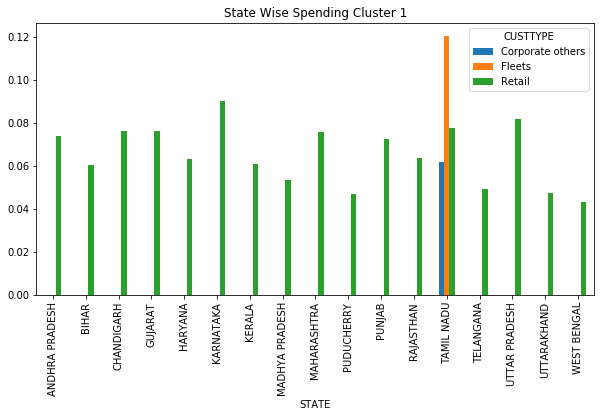

In [111]:
#For cluster with high cost group with customer type & Order type (Service)
res = df[df.cluster == 1]
print(res.shape)
res = res.pivot_table(index='STATE', columns='CUSTTYPE',values='TOTALAMTWTDTAX').reset_index()
res.plot(kind='bar', title = "State Wise Spending Cluster 1", figsize=(10,5),x='STATE')
plt.xticks(fontsize =10 , rotation=90);

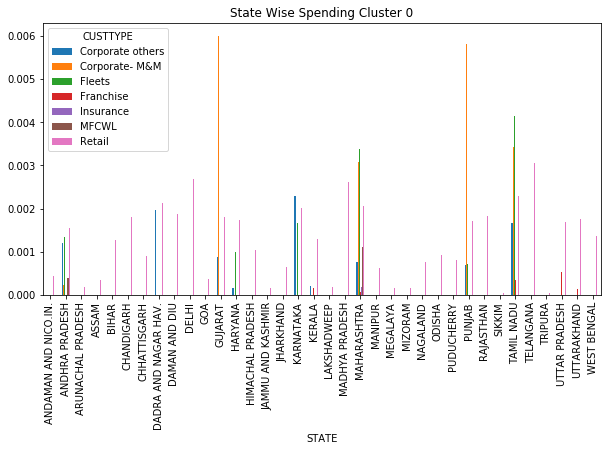

In [114]:
#For cluster with high cost group with customer type & Order type (Service)
res = df[df.cluster == 0]
res = res.pivot_table(index='STATE', columns='CUSTTYPE',values='TOTALAMTWTDTAX').reset_index()
res.plot(kind='bar', title = "State Wise Spending Cluster 0", figsize=(10,5),x='STATE')
plt.xticks(fontsize =10 , rotation=90);